# Homeowners vs. Student Loan Holders

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.feature_extraction.text import TfidfVectorizer


# Perform Exploratory Data Analysis

1. Read in file
2. Look over some descriptive statistics

## 1. Read in file

In [2]:
# Read in "after_collection" dataframe
acdf = pd.read_csv('./data/after_collection.csv')

## 2. Look over some descriptive statistics

In [3]:
# Check info for dtypes and nulls
acdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5080 entries, 0 to 5079
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ids          5080 non-null   object
 1   title        5080 non-null   object
 2   body         5080 non-null   object
 3   comments     5080 non-null   int64 
 4   upvotes      5080 non-null   int64 
 5   subreddit    5080 non-null   object
 6   post_length  5080 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 277.9+ KB


In [4]:
# Describe numerical columns
acdf.describe()

,comments,upvotes,post_length
count,5080.000000,5080.000000,5080.000000
mean,9.694882,11.355512,704.469685
std,24.656950,86.138597,591.227509
min,0.000000,0.000000,27.000000
25%,2.000000,1.000000,338.000000
50%,5.000000,2.000000,553.000000
75%,10.000000,3.000000,882.000000
max,584.000000,4905.000000,7542.000000


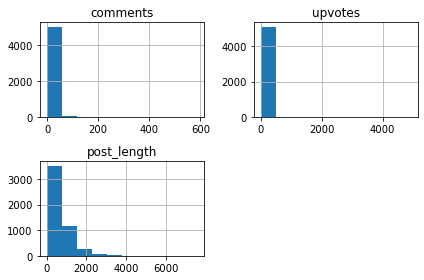

In [5]:
# Check distribution of numeric columns
acdf.hist()
plt.tight_layout();

Findings:
1. "subreddit" columns must be binarized
2. All numeric columns positively skewed

# Engineer Features, Clean, and Format Data
1. Binarize "subreddit" column
2. Body cleaning
    1. Sentiment analysis
    2. Word counts
    3. Parts of speech
    4. Extracting important words
    5. Extracting noun_chunks

## 1. Binarize "subreddit" column

In [6]:
# Map subreddit columns to 1/0
acdf['subreddit'] = acdf['subreddit'].map({'StudentLoans':1, 'HomeImprovement':0})

## 2. Body cleaning 

### Sentiment analysis

In [7]:
# Load english spacy
sp = spacy.load('en_core_web_sm')

In [8]:
# Add spacytextblob
sp.add_pipe('spacytextblob')

In [9]:
# Iterate over "body" column and run .polarity
acdf['sentiment'] = [sp(text)._.polarity for text in acdf['body']]

### Word count

In [10]:
# Split "body" column and count elements
acdf['word_count'] = [len(text.split(' ')) for text in acdf['body']]

### Parts of speech

In [11]:
# Create parts of speech dictionary
pos_acdf = pd.DataFrame([Counter([word.pos_ for word in sp(text)]) for text in acdf['body']])

In [12]:
# Create pos_ columns with usage rates
for title in pos_acdf.columns:
    acdf['pos_'+title] = pos_acdf[title]
    acdf.fillna(0, inplace=True)
    acdf['pos_'+title] = acdf['pos_'+title]/acdf['word_count']

### Extracting important words

In [13]:
# Create lemmatized body column
acdf['lemma_body'] = [' '.join([word.lemma_ for word in sp(text)]) for text in acdf['body']]

In [14]:
# Instantiaie tfidf
tfidf = TfidfVectorizer(stop_words='english',
                        strip_accents = 'ascii',
                        max_features = 60,
                        max_df = .10,
                        norm = 'l2')

In [15]:
# Fit tfidf on lemmatized body column
tfidf.fit(acdf.lemma_body)

TfidfVectorizer(max_df=0.1, max_features=60, stop_words='english',
                strip_accents='ascii')

In [16]:
# Create vectorized columns
acdf_v = pd.DataFrame(tfidf.transform(acdf.lemma_body).todense(),
                    columns=tfidf.get_feature_names())

# Create list of non-letter columns
non_let_cols = [col for col in acdf_v.columns for char in col if char not in 'abcdefghijklmnopqrstuvwxyz']

In [17]:
# Analyze columns to identify leaking
acdf_v.columns

Index(['000', '10', 'able', 'apply', 'appreciate', 'area', 'ask', 'build',
       'close', 'college', 'company', 'cost', 'cover', 'credit', 'currently',
       'day', 'debt', 'degree', 'door', 'end', 'federal', 'feel', 'fix',
       'floor', 'graduate', 'hi', 'high', 'income', 'instal', 'issue', 'job',
       'leave', 'light', 'line', 'live', 'll', 'long', 'lot', 'low', 'money',
       'option', 'paint', 'parent', 'place', 'possible', 'post', 'private',
       'program', 'rate', 'remove', 'room', 'run', 'small', 'tell', 'tile',
       'total', 'water', 'window', 'wonder', 'wood'],
      dtype='object')

In [18]:
# Drop non-letter and leaking columns
acdf_v.drop(columns=non_let_cols, inplace=True)

In [19]:
# Concatenate fdf/fdf_v dataframes
acdf = pd.concat([acdf,acdf_v], axis=1)

### Extracting noun_chunks

Create noun_chunks dataframe as nc_df with the following steps:
1. Iterate over "lemma_body" column with variable "text" in list comprehension
2. Iterate over posts with variable "term" in nested list comprehension to find noun_chunks
3. Create dictionary with count of each term converted to string and ' ' replaced with '_'
4. Create Dataframe out of dictionary

In [29]:
nc_df = pd.DataFrame([Counter([str(term).replace(' ','_') for term in sp(text)\
           .noun_chunks if len(str(term).split(' ')) > 1])\
           for text in acdf['lemma_body']])

In [30]:
# Fill nans with 0
nc_df.fillna(0, inplace=True)

In [31]:
# Keep top 150 most frequent noun_chunks
nc_df = nc_df[pd.DataFrame(nc_df.sum().sort_values(ascending=False))[:150].T.columns]

In [32]:
# List potential leakers
potential_leakers = ['the_house', 'the_loan', 'student_loan', 'my_loan','a_house', 'my_house',
                     'a_loan', 'my_student_loan', 'federal_loan', 'private_loan',
                     'our_house', 'a_student_loan', 'this_loan', 'a_home']

In [33]:
# Add in "subreddit" column to further examine leakers
nc_df['target'] = acdf['subreddit']

In [34]:
# Further examine potential leakers
nc_df.groupby('target')[potential_leakers].mean()

,the_house,the_loan,student_loan,my_loan,a_house,my_house,a_loan,my_student_loan,federal_loan,private_loan,our_house,a_student_loan,this_loan,a_home
target,,,,,,,,,,,,,,
0,0.174942,0.001973,0.000000,0.000000,0.044393,0.059191,0.000000,0.000000,0.000000,0.000000,0.030911,0.000000,0.000000,0.009207
1,0.005885,0.175086,0.155468,0.171653,0.033350,0.002943,0.077489,0.071604,0.059343,0.055419,0.001962,0.030407,0.027955,0.011280


In [35]:
# Select actual leakers
leakers = ['the_house', 'the_loan', 'my_loan','student_loan', 'my_house', 'a_loan', 'my_student_loan', 'federal_loan',
           'private_loan', 'our_house', 'a_student_loan', 'this_loan']

In [36]:
# Drop actual leakers
nc_df.drop(columns=leakers, inplace=True)

In [37]:
# Drop target
nc_df.drop(columns=['target'], inplace=True)

In [38]:
# Add noun_chunks to after_collection dataframe
acdf = pd.concat([acdf,nc_df], axis=1)

# Further Exploratory Data Analysis and Visualizations
1. Explore Parts of Speech
2. Explore Word Count
3. Explore Sentiment Analysis
4. Explore Popular Words
5. Explore Noun Chunks

## 1. Explore Parts of Speech

In [39]:
# Create Parts of Speech DataFrame
pos_df = acdf.groupby('subreddit')[acdf.columns[9:27]].mean().T.reset_index()

In [40]:
# Rename Parts of Speech column after index was reset
pos_df.rename(columns={'index':'pos'}, inplace=True)

In [41]:
# Create pos ratio column
pos_df['pos_ratio'] = pos_df[0]/pos_df[1]

In [42]:
# Sort values by "pos_ratio"
pos_df = pos_df.sort_values(['pos_ratio'])

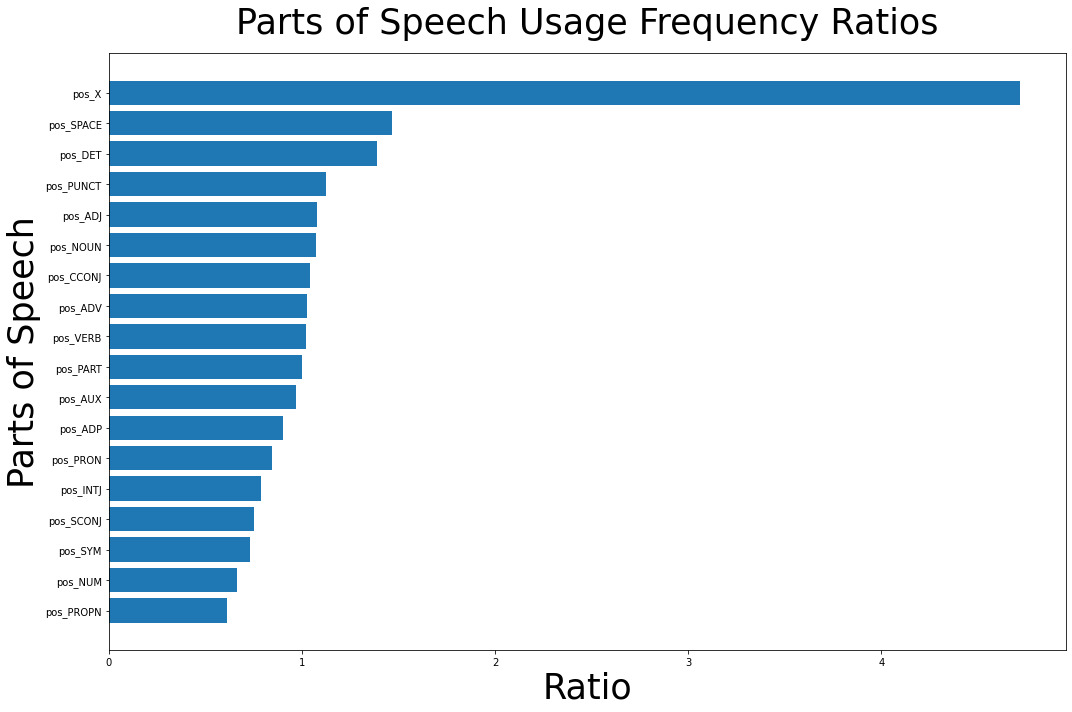

In [43]:
# Create Bar graph of ratio
fig, ax = plt.subplots(1,1, figsize=(15,10))

ax.set_title('Parts of Speech Usage Frequency Ratios', loc='center', size=35, pad=20)
ax.tick_params(zorder='auto')
ax.barh(pos_df['pos'], pos_df['pos_ratio'])
ax.set_xlabel('Ratio', size=35)
ax.set_ylabel('Parts of Speech', size=35)

plt.tight_layout();

## 2. Explore Word Count

In [44]:
# Average Word count per post
acdf.groupby('subreddit')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,3041.0,118.196646,90.901205,1.0,60.0,96.0,144.0,1019.0
1,2039.0,139.986268,125.399173,7.0,64.0,108.0,176.0,1362.0


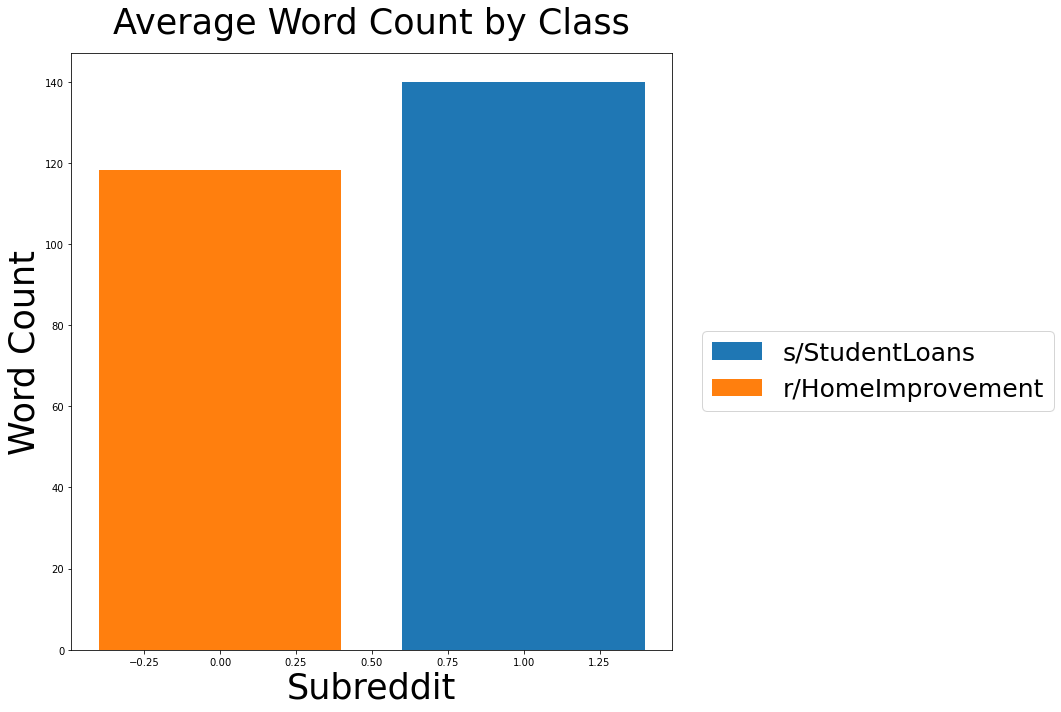

In [45]:
# Create Bar graph of ratio
fig, ax = plt.subplots(1,1, figsize=(15,10))

ax.set_title('Average Word Count by Class', loc='center', size=35, pad=20)
ax.bar(acdf[acdf['subreddit']==1]['subreddit'],
           acdf[acdf['subreddit']==1]['word_count'].mean(),label = 's/StudentLoans')
ax.bar(acdf[acdf['subreddit']==0]['subreddit'],
           acdf[acdf['subreddit']==0]['word_count'].mean(),label = 'r/HomeImprovement')
ax.set_xlabel('Subreddit', size=35)
ax.set_ylabel('Word Count', size=35)
ax.legend(loc = (1.05, .4), prop={'size':25})

plt.tight_layout();

Hypothesis Test:
1. H0: The number of words per post in r/HomeImprovement >= r/StudnetLoans
2. H1: The number of words per post in r/HomeImprovement < r/StudentLoans

In [48]:
# Run a hypothesis test on the word counts
SLavg = 139
HIavg = 118
SLn = 2039
HIn = 3041
SLstd = 123
HIstd = 93
# Determine test statistic
test_stat = (SLavg-HIavg)/np.sqrt((SLstd**2)/SLn + (HIstd**2)/HIn)
print(f'Test Statistic: {test_stat}')
# Set Z score determined by desired conf int
conf_99 = 2.58
if (conf_99-test_stat) >= 0:
    print('Fail to reject Null Hypothesis')
else:
    print('Reject the null hypothesis')

Test Statistic: 6.5548409902788665
Reject the null hypothesis


## 3. Explore Sentiment Analysis

In [47]:
# Average sentiment score per post
acdf.groupby('subreddit')['sentiment'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,3041.0,0.079038,0.148232,-1.0,0.00000,0.077778,0.157143,1.0
1,2039.0,0.094793,0.136396,-0.4,0.00097,0.089654,0.166667,1.0


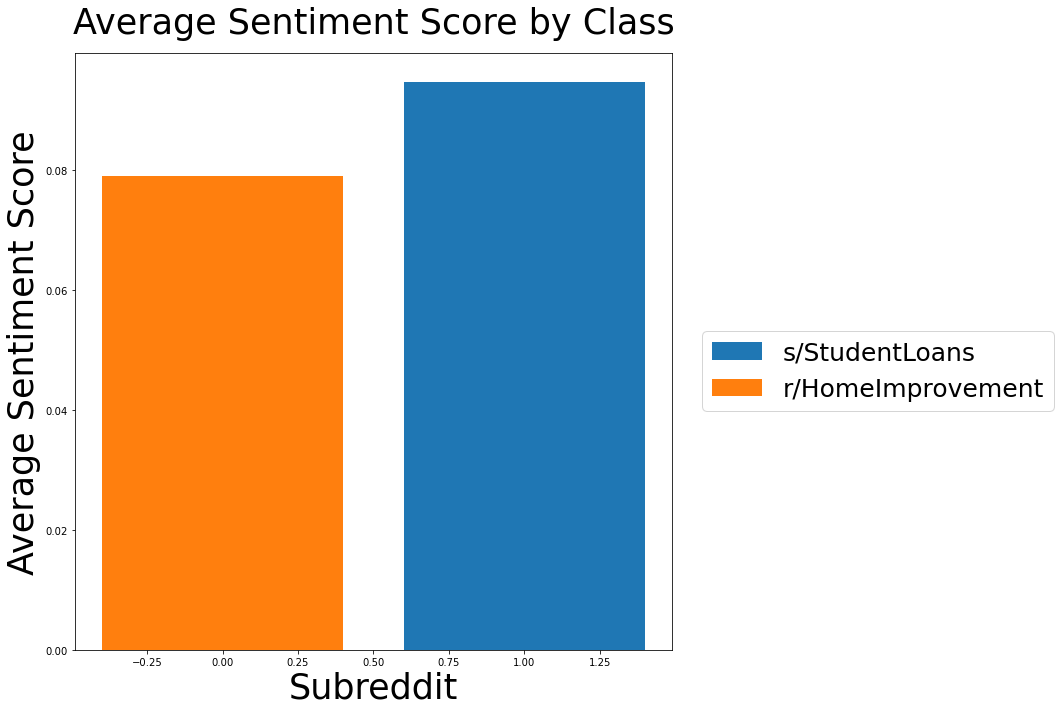

In [49]:
# Create Bar graph of ratio
fig, ax = plt.subplots(1,1, figsize=(15,10))

ax.set_title('Average Sentiment Score by Class', loc='center', size=35, pad=20)
ax.bar(acdf[acdf['subreddit']==1]['subreddit'],
           acdf[acdf['subreddit']==1]['sentiment'].mean(),label = 's/StudentLoans')
ax.bar(acdf[acdf['subreddit']==0]['subreddit'],
           acdf[acdf['subreddit']==0]['sentiment'].mean(),label = 'r/HomeImprovement')
ax.set_xlabel('Subreddit', size=35)
ax.set_ylabel('Average Sentiment Score', size=35)
ax.legend(loc = (1.05, .4), prop={'size':25})

plt.tight_layout();

Hypothesis Test:
1. H0: The sentiment analysis mean score of r/HomeImprovement >= r/StudnetLoans
2. H1: The sentiment analysis mean score of r/HomeImprovement < r/StudentLoans

In [50]:
# Run a hypothesis test on the sentiment analysis
SLavg = .0948
HIavg = .0794
SLn = 2039
HIn = 3041
SLstd = .1364
HIstd = .1482
# Determine test statistic
test_stat = (SLavg-HIavg)/np.sqrt((SLstd**2)/SLn + (HIstd**2)/HIn)
print(f'Test Statistic: {test_stat}')
# Set Z score determined by desired conf int
conf_99 = 2.58
if (conf_99-test_stat) >= 0:
    print('Fail to reject Null Hypothesis')
else:
    print('Reject the null hypothesis')

Test Statistic: 3.808927265662895
Reject the null hypothesis


## 4. Explore Popular Words

In [51]:
# Create words DataFrame
word_df = acdf.groupby('subreddit')[acdf.columns[28:86]].mean().T.reset_index()

In [52]:
# Rename Word column after index was reset
word_df.rename(columns={'index':'word'}, inplace=True)

In [53]:
# Create word difference column
word_df['word_difference'] = word_df[0]- word_df[1]

In [58]:
# Sort values by "word_differnce"
word_df = word_df.sort_values(['word_difference'])

In [59]:
# Show word_df
word_df

subreddit,word,0,1,word_difference
14,debt,0.000000,0.092415,-0.092415
18,federal,0.000628,0.088673,-0.088045
11,credit,0.000564,0.087217,-0.086653
44,private,0.000445,0.079603,-0.079157
7,college,0.000527,0.075317,-0.074790
22,graduate,0.000000,0.070429,-0.070429
37,money,0.006423,0.073368,-0.066945
46,rate,0.004015,0.069468,-0.065453
40,parent,0.002996,0.062286,-0.059289
25,income,0.000662,0.058175,-0.057513


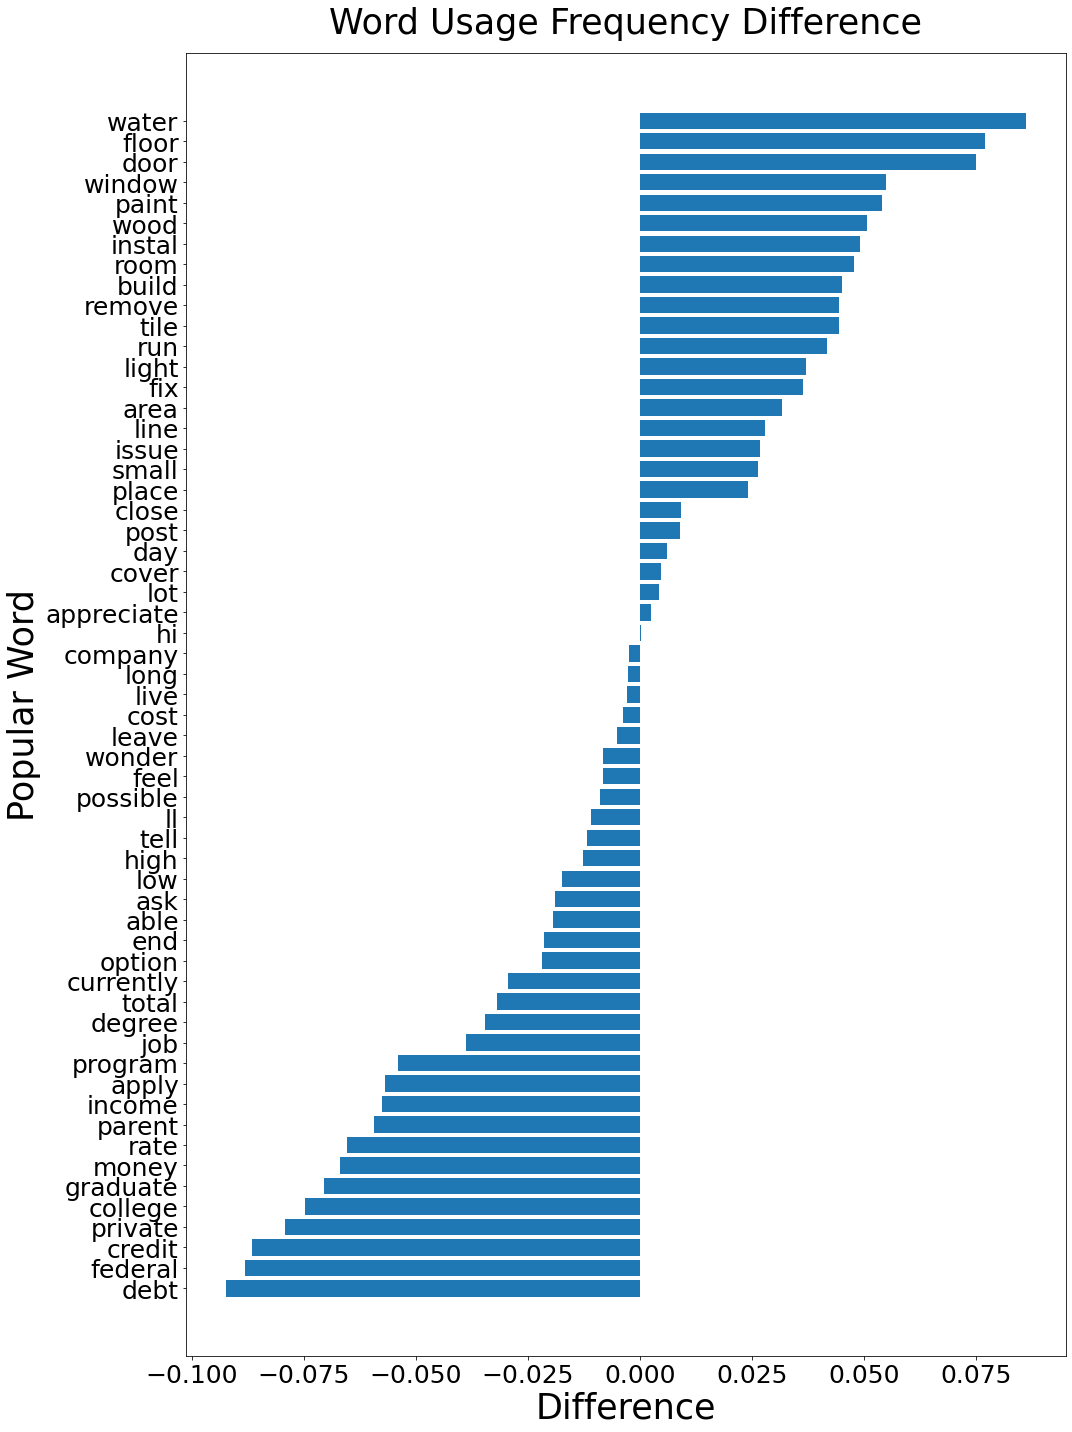

In [60]:
# Create Bar graph of difference
fig, ax = plt.subplots(1,1, figsize=(15,20))

ax.set_title('Word Usage Frequency Difference', loc='center', size=35, pad=20)
ax.tick_params(labelsize=25,zorder='auto')
ax.barh(word_df['word'], word_df['word_difference'])
ax.set_xlabel('Difference', size=35)
ax.set_ylabel('Popular Word', size=35)

plt.tight_layout();

## 5. Explore Noun Chunks

In [66]:
# Create Noun Chunks DataFrame
chunk_df = acdf.groupby('subreddit')[acdf.columns[86:]].mean().T.reset_index()

In [67]:
# Rename term column after index was reset
chunk_df.rename(columns={'index':'term'}, inplace=True)

In [68]:
# Create noun chunk difference column
chunk_df['chunk_difference'] = chunk_df[0]- chunk_df[1]

In [69]:
# Sort values by "chunk_difference"
chunk_df = chunk_df.sort_values(['chunk_difference'])

In [70]:
# Show chunk_df
chunk_df

subreddit,term,0,1,chunk_difference
2,my_parent,0.005590,0.131927,-0.126337
14,the_money,0.001973,0.066699,-0.064726
16,grad_school,0.000658,0.065228,-0.064570
24,the_school,0.000000,0.056400,-0.056400
39,Sallie_Mae,0.000000,0.047572,-0.047572
...,...,...,...,...
11,the_water,0.049326,0.000000,0.049326
9,the_basement,0.051628,0.000000,0.051628
6,the_door,0.064452,0.000981,0.063472
4,the_floor,0.078264,0.000000,0.078264


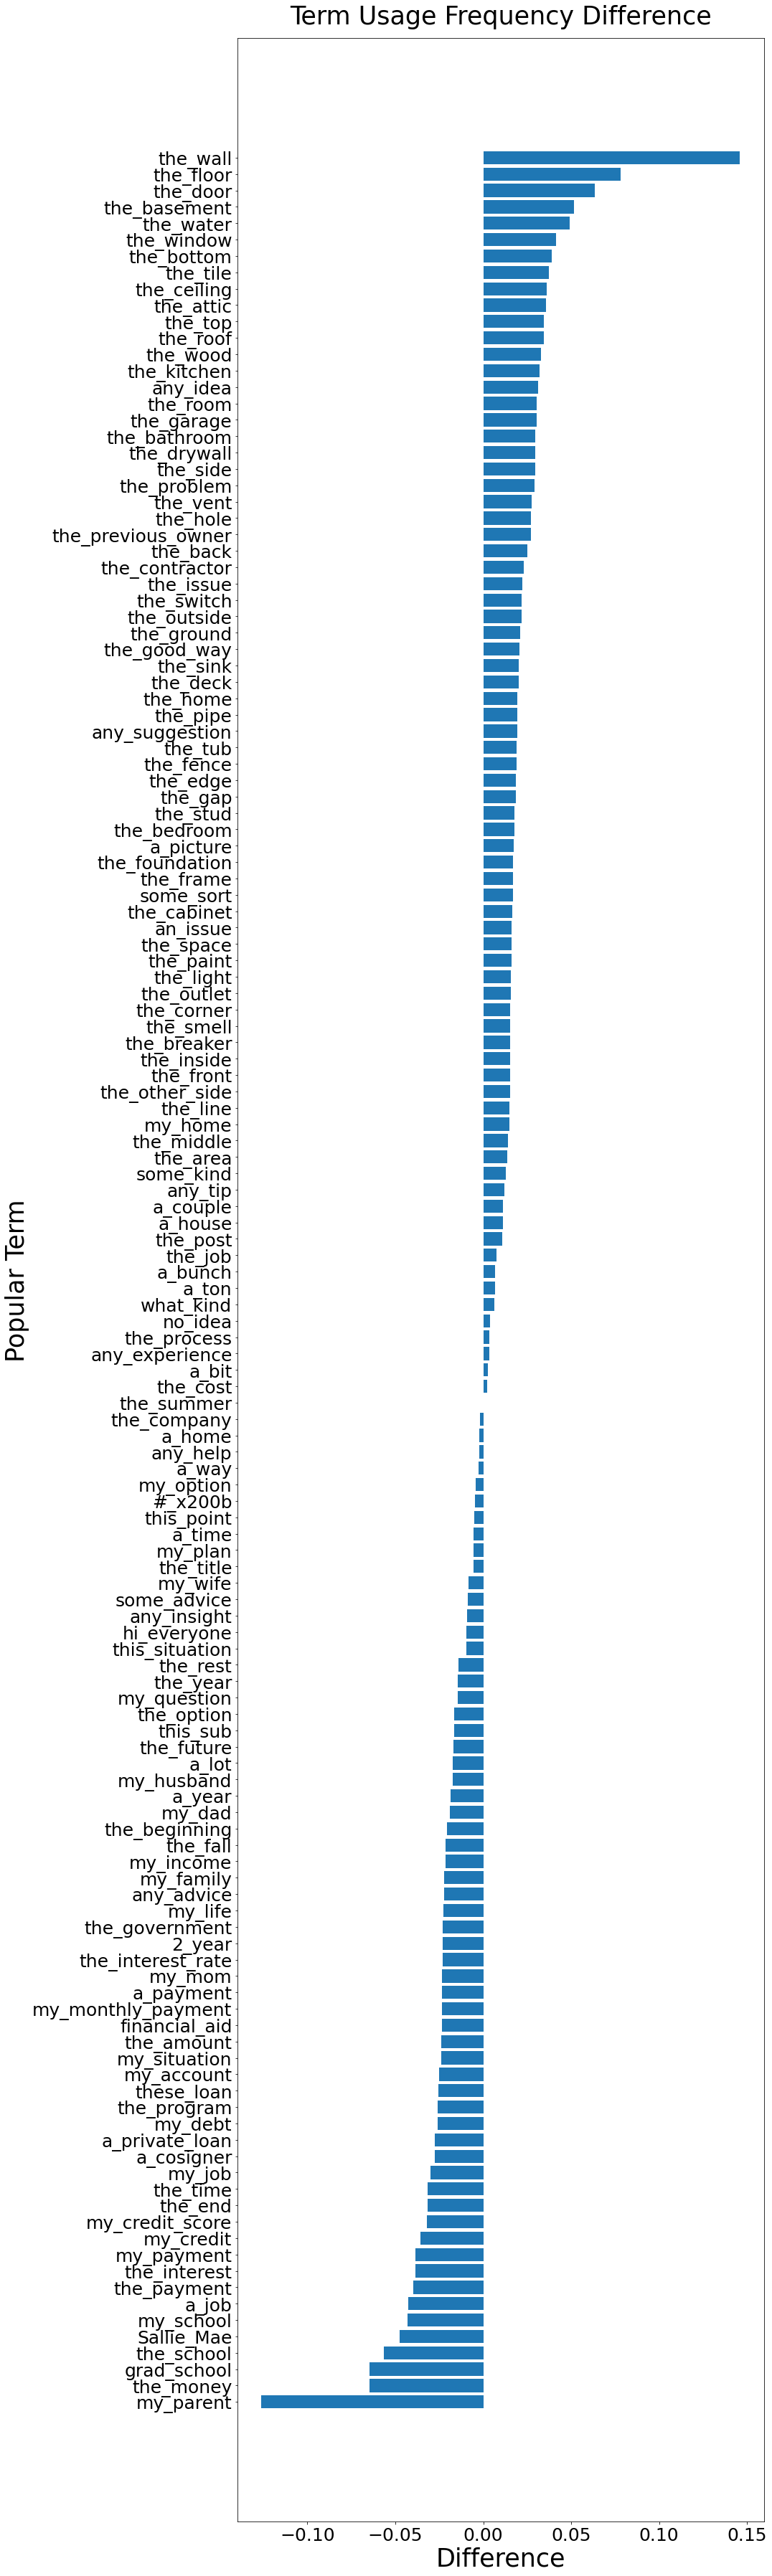

In [71]:
# Create Bar graph of difference
fig, ax = plt.subplots(1,1, figsize=(15,50))

ax.set_title('Term Usage Frequency Difference', loc='center', size=35, pad=20)
ax.tick_params(labelsize=25,zorder='auto')
ax.barh(chunk_df['term'], chunk_df['chunk_difference'])
ax.set_xlabel('Difference', size=35)
ax.set_ylabel('Popular Term', size=35)

plt.tight_layout();

In [72]:
# Save cleaned dataframe as cleaned_dataframe.csv
acdf.to_csv('./data/cleaned_dataframe.csv', index=False)

In [73]:
chunk_df.to_csv('./data/noun_chunks.csv', index=False)

In [74]:
word_df.to_csv('./data/pop_words.csv', index=False)

In [75]:
pos_df.to_csv('./data/parts_speech.csv', index=False)